# The Great Doodle Detective: CNN Edition

**Can you train a neural network to understand your terrible drawings?**

You know that friend who draws a "cat" and it looks like a possessed potato? Or claims their scribble is "obviously a bicycle"? Well, today YOU become the detective — training a Convolutional Neural Network to decode humanity's worst artistic attempts.

Using data from Google's Quick Draw dataset (millions of doodles drawn by real humans in under 20 seconds), you'll build a CNN that classifies hand-drawn doodles into categories like cat, dog, car, and house.

---

### What You'll Build:
1. Load and visualize chaotic human doodles
2. Build a CNN architecture from scratch
3. Train your model to recognize patterns in the madness
4. Test it on your own drawings

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


---

## Part 1: Loading the Doodle Data (PROVIDED)

We'll generate synthetic "doodle-like" data for this exercise. In the real world, you'd download from [Google Quick Draw](https://quickdraw.withgoogle.com/data).

Our synthetic doodles will have distinctive patterns for each class:
- **Cat**: Triangular ear-like shapes + circular features
- **Dog**: Floppy ear shapes + snout-like features  
- **Car**: Rectangular body + circular wheels
- **House**: Triangular roof + rectangular base

Each doodle is 28×28 pixels (like MNIST), grayscale, with values 0-255.

In [14]:
def generate_doodle(category, size=28):
    """Generate a synthetic doodle. Returns a 28x28 numpy array."""
    img = np.zeros((size, size), dtype=np.float32)
    noise = np.random.normal(0, 15, (size, size))
    ox, oy = np.random.randint(-3, 4), np.random.randint(-3, 4)
    
    if category == 0:  # Cat
        # Ears
        for i in range(5):
            for j in range(5-i):
                y, x = 4+i+oy, 6+j+ox
                if 0 <= y < size and 0 <= x < size:
                    img[y, x] = 200 + np.random.randint(-30, 30)
        for i in range(5):
            for j in range(5-i):
                y, x = 4+i+oy, 18-j+ox
                if 0 <= y < size and 0 <= x < size:
                    img[y, x] = 200 + np.random.randint(-30, 30)
        # Face
        for i in range(10):
            for j in range(12):
                y, x = 10+i+oy, 8+j+ox
                if 0 <= y < size and 0 <= x < size:
                    img[y, x] = 180 + np.random.randint(-20, 20)
        # Whiskers
        for j in range(6):
            y, x = 16+oy, 2+j+ox
            if 0 <= y < size and 0 <= x < size:
                img[y, x] = 220
            y, x = 16+oy, 20+j+ox
            if 0 <= y < size and 0 <= x < size:
                img[y, x] = 220
                
    elif category == 1:  # Dog
        # Floppy ears
        for i in range(8):
            for j in range(4):
                y, x = 6+i+oy, 4+j+ox
                if 0 <= y < size and 0 <= x < size:
                    img[y, x] = 190 + np.random.randint(-20, 20)
        for i in range(8):
            for j in range(4):
                y, x = 6+i+oy, 20+j+ox
                if 0 <= y < size and 0 <= x < size:
                    img[y, x] = 190 + np.random.randint(-20, 20)
        # Face
        for i in range(10):
            for j in range(12):
                y, x = 8+i+oy, 8+j+ox
                if 0 <= y < size and 0 <= x < size:
                    img[y, x] = 170 + np.random.randint(-20, 20)
        # Snout
        for i in range(4):
            for j in range(6):
                y, x = 18+i+oy, 11+j+ox
                if 0 <= y < size and 0 <= x < size:
                    img[y, x] = 200 + np.random.randint(-20, 20)
                    
    elif category == 2:  # Car
        # Body
        for i in range(6):
            for j in range(20):
                y, x = 10+i+oy, 4+j+ox
                if 0 <= y < size and 0 <= x < size:
                    img[y, x] = 180 + np.random.randint(-20, 20)
        # Top
        for i in range(4):
            for j in range(10):
                y, x = 6+i+oy, 9+j+ox
                if 0 <= y < size and 0 <= x < size:
                    img[y, x] = 160 + np.random.randint(-20, 20)
        # Wheels
        for i in range(4):
            for j in range(4):
                y, x = 16+i+oy, 6+j+ox
                if 0 <= y < size and 0 <= x < size:
                    img[y, x] = 220 + np.random.randint(-20, 20)
        for i in range(4):
            for j in range(4):
                y, x = 16+i+oy, 18+j+ox
                if 0 <= y < size and 0 <= x < size:
                    img[y, x] = 220 + np.random.randint(-20, 20)
                    
    elif category == 3:  # House
        # Roof
        for i in range(8):
            width = 2 * (8-i)
            start = 14 - (8-i)
            for j in range(width):
                y, x = 2+i+oy, start+j+ox
                if 0 <= y < size and 0 <= x < size:
                    img[y, x] = 200 + np.random.randint(-30, 30)
        # Base
        for i in range(10):
            for j in range(14):
                y, x = 10+i+oy, 7+j+ox
                if 0 <= y < size and 0 <= x < size:
                    img[y, x] = 170 + np.random.randint(-20, 20)
        # Door
        for i in range(6):
            for j in range(4):
                y, x = 14+i+oy, 12+j+ox
                if 0 <= y < size and 0 <= x < size:
                    img[y, x] = 100 + np.random.randint(-20, 20)
    
    img = img + noise
    img = np.clip(img, 0, 255)
    return img


CATEGORIES = ['cat', 'dog', 'car', 'house']
N_PER_CLASS = 500

X_data = []
y_data = []

for cat_idx, cat_name in enumerate(CATEGORIES):
    for _ in range(N_PER_CLASS):
        doodle = generate_doodle(cat_idx)
        X_data.append(doodle)
        y_data.append(cat_idx)

X_data = np.array(X_data)
y_data = np.array(y_data)

shuffle_idx = np.random.permutation(len(X_data))
X_data = X_data[shuffle_idx]
y_data = y_data[shuffle_idx]

print(f"Generated {len(X_data)} doodles across {len(CATEGORIES)} categories")
print(f"Image shape: {X_data[0].shape}")

Generated 2000 doodles across 4 categories
Image shape: (28, 28)


### Sample Doodles

Let's see what we're working with:

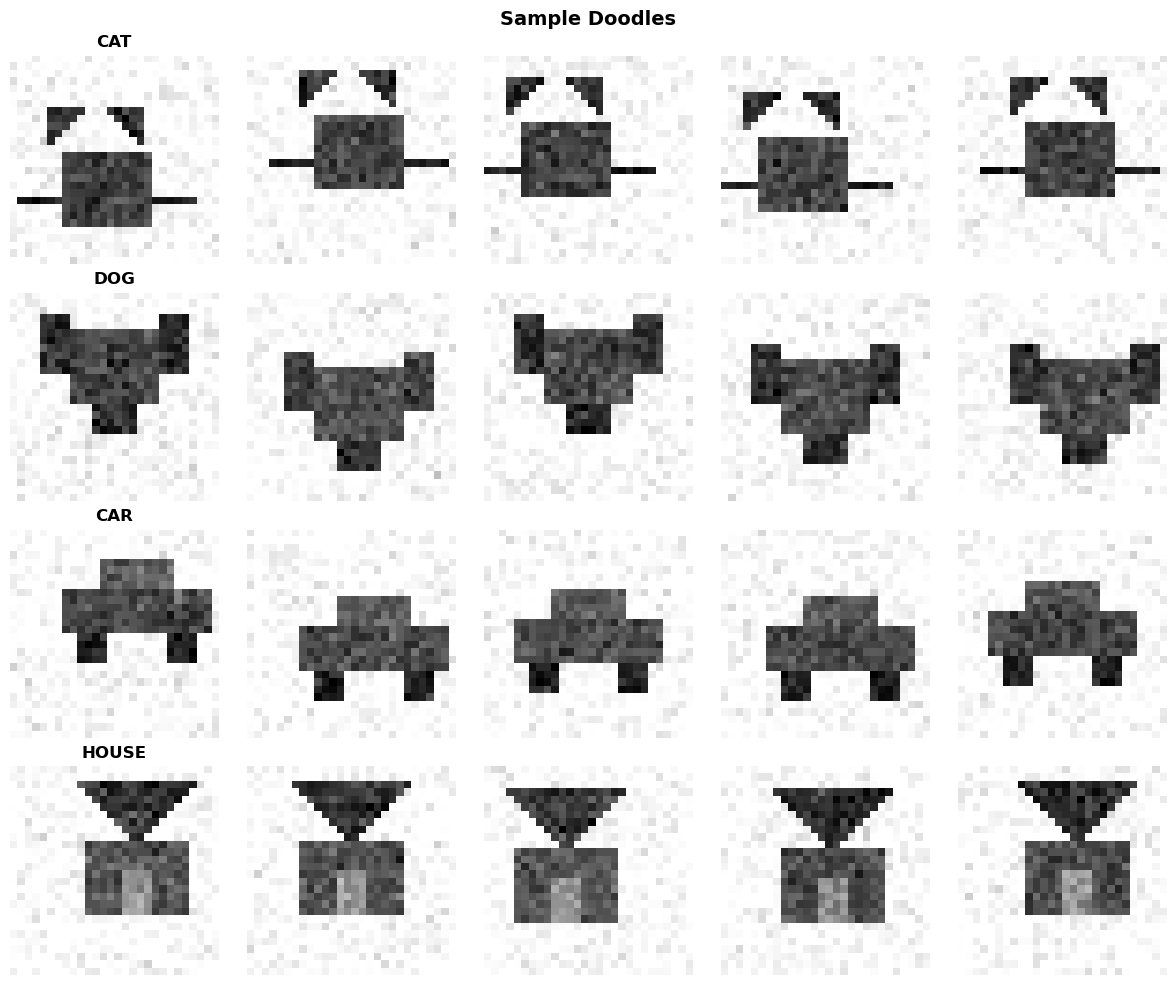

In [15]:
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
fig.suptitle("Sample Doodles", fontsize=14, fontweight='bold')

for row, cat_idx in enumerate([0, 1, 2, 3]):
    cat_samples = X_data[y_data == cat_idx][:5]
    for col, sample in enumerate(cat_samples):
        axes[row, col].imshow(sample, cmap='gray_r')
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_title(f"{CATEGORIES[cat_idx].upper()}", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### Warm-Up Questions

1. Looking at the sample doodles, which two categories do you think will be hardest for the CNN to distinguish? Why?

2. What visual features seem most distinctive for each category?

### A:
YOUR ANSWERS HERE

1. Shape and the number of triangles

2. The length of the sides seem the most distinctive for each category. For example, the house has 3 sets of equal side pairs, wheras the car has 6.

---

## Part 2: Preparing Data for PyTorch (PROVIDED)

Before feeding data to a CNN, we need to:
1. **Normalize** pixel values to [0, 1] range (helps training converge faster)
2. **Split** into training and test sets
3. **Convert** to PyTorch tensors
4. **Add channel dimension** (CNNs expect shape: [batch, channels, height, width])

In [16]:
# Normalize to [0, 1]
X_normalized = X_data / 255.0

# Train/test split (80/20)
split_idx = int(0.8 * len(X_normalized))
X_train, X_test = X_normalized[:split_idx], X_normalized[split_idx:]
y_train, y_test = y_data[:split_idx], y_data[split_idx:]

# Convert to tensors, add channel dim: (N, 28, 28) -> (N, 1, 28, 28)
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(1)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

BATCH_SIZE = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 1600
Test samples: 400


---

## Part 3: Build Your CNN

Now it's your turn to build the classifier.

### Architecture Overview
```
Input: 1x28x28 (grayscale doodle)
        |
Conv2d(1->16, 3x3) + ReLU + MaxPool(2x2)  ->  16x13x13
        |
Conv2d(16->32, 3x3) + ReLU + MaxPool(2x2) ->  32x5x5
        |
Flatten -> 32*5*5 = 800 features
        |
Linear(800->64) + ReLU
        |
Linear(64->4)  ->  4 class logits
```

Fill in the `TODO` sections below.

In [17]:
class DoodleDetective(nn.Module):
    def __init__(self, num_classes=4):
        super(DoodleDetective, self).__init__()
        
        # TODO: First conv layer - 1 input channel, 16 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        
        # TODO: Second conv layer - 16 input channels, 32 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        # TODO: First linear layer - 800 inputs (32*5*5), 64 outputs
        self.fc1 = nn.Linear(32 * 5 * 5, 64)
        
        # TODO: Output layer - 64 inputs, num_classes outputs
        self.fc2 = nn.Linear(64, num_classes)

    
    def forward(self, x):
        # Input: (batch, 1, 28, 28)
        
        # TODO: First conv block - conv1 -> relu -> pool
        x = self.pool(self.relu(self.conv1(x)))

        
        # TODO: Second conv block - conv2 -> relu -> pool
        x = self.pool(self.relu(self.conv2(x))) 
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # TODO: Fully connected layers - fc1 -> relu -> fc2
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


model = DoodleDetective(num_classes=4).to(device)
print("Model architecture:")
print(model)

# Test forward pass
dummy_input = torch.randn(1, 1, 28, 28).to(device)
try:
    dummy_output = model(dummy_input)
    print(f"\nForward pass OK! Output shape: {dummy_output.shape}")
except Exception as e:
    print(f"\nError: {e}")

Model architecture:
DoodleDetective(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=800, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

Forward pass OK! Output shape: torch.Size([1, 4])


---

## Part 4: Training

Fill in the training loop below.

In [18]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
train_accuracies = []

print("Training...")
print("=" * 50)

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # TODO: Forward pass
        outputs = model(images)
        
        # TODO: Compute loss
        loss = criterion(outputs, labels)
        
        # TODO: Backward pass
        loss.backward()
        
        # TODO: Update weights
        optimizer.step()
        
        # Stats
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}%")

print("=" * 50)
print("Done!")

Training...
Epoch [1/10] Loss: 0.8652 Acc: 77.12%
Epoch [2/10] Loss: 0.0482 Acc: 99.75%
Epoch [3/10] Loss: 0.0058 Acc: 100.00%
Epoch [4/10] Loss: 0.0023 Acc: 100.00%
Epoch [5/10] Loss: 0.0013 Acc: 100.00%
Epoch [6/10] Loss: 0.0008 Acc: 100.00%
Epoch [7/10] Loss: 0.0005 Acc: 100.00%
Epoch [8/10] Loss: 0.0004 Acc: 100.00%
Epoch [9/10] Loss: 0.0003 Acc: 100.00%
Epoch [10/10] Loss: 0.0002 Acc: 100.00%
Done!


### Visualize Training Progress

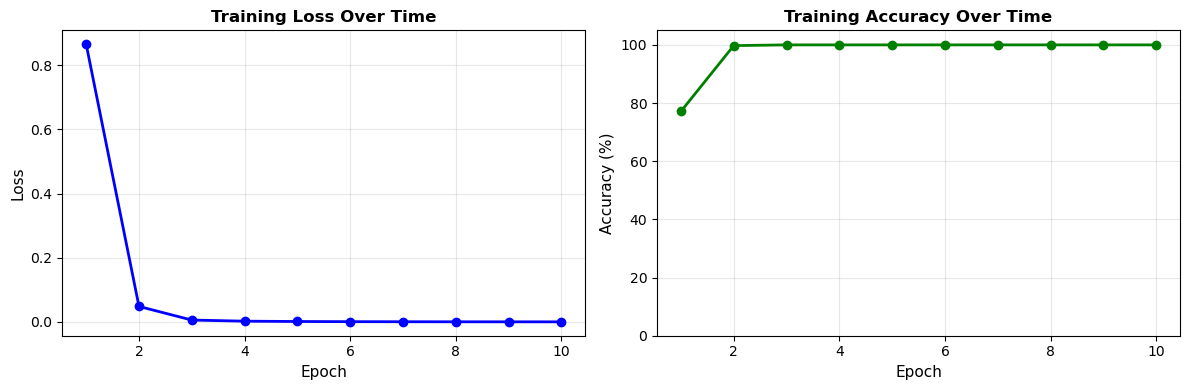

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
ax1.plot(range(1, NUM_EPOCHS+1), train_losses, 'b-o', linewidth=2, markersize=6)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Loss', fontsize=11)
ax1.set_title('Training Loss Over Time', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(range(1, NUM_EPOCHS+1), train_accuracies, 'g-o', linewidth=2, markersize=6)
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Accuracy (%)', fontsize=11)
ax2.set_title('Training Accuracy Over Time', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 105])

plt.tight_layout()
plt.show()

---

## Part 5: Evaluation

How well does the model perform on unseen doodles? Complete the evaluation loop.

In [21]:
def evaluate_model(model, test_loader, device):
    """Evaluate on test set. Returns accuracy and predictions."""
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Get predicted class
            _, predicted = torch.max(outputs, dim=1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    return accuracy, np.array(all_predictions), np.array(all_labels)


test_accuracy, predictions, true_labels = evaluate_model(model, test_loader, device)

print("Test Results")
print("=" * 40)
print(f"Accuracy: {test_accuracy:.2f}%")
print(f"Correct: {int(test_accuracy * len(true_labels) / 100)}/{len(true_labels)}")


Test Results
Accuracy: 100.00%
Correct: 400/400


### Confusion Matrix

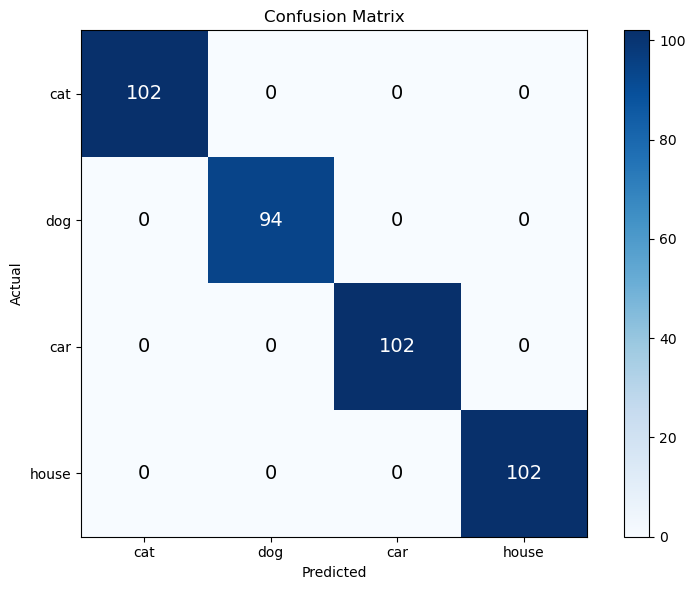


Classification Report:
              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       102
         dog       1.00      1.00      1.00        94
         car       1.00      1.00      1.00       102
       house       1.00      1.00      1.00       102

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



In [22]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', 
                 color='white' if cm[i, j] > cm.max()/2 else 'black', fontsize=14)

plt.xticks(range(4), CATEGORIES)
plt.yticks(range(4), CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=CATEGORIES))

### Evaluation Questions

1. Which doodle category is easiest for the model? Which is hardest?

2. Looking at the confusion matrix, which categories get mixed up the most? Does this make sense visually?

### A:
YOUR ANSWERS HERE

1.The cat, car, and house are the easiest for the model, while the dog is the hardest.

2. There are no visible mixups in categories in the matrix. This means that the model could be accurate with its dataset, being able to distinctly recognize the four different objects.

---

## Part 6: Test Your Own Doodles

Let's test on some edge cases:

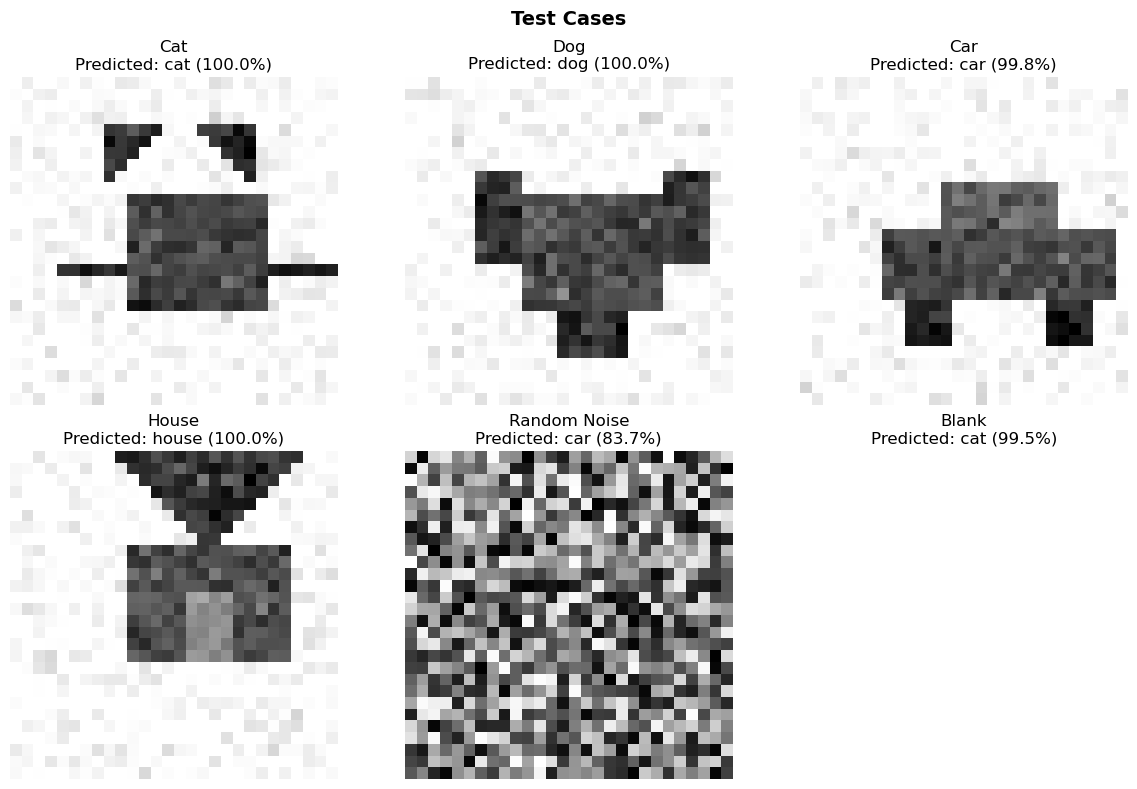

In [23]:
def predict_doodle(model, doodle, device):
    """Predict class for a single doodle."""
    model.eval()
    doodle_tensor = torch.FloatTensor(doodle / 255.0).unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(doodle_tensor)
        probs = torch.softmax(outputs, dim=1)[0]
        pred_class = torch.argmax(probs).item()
    
    return CATEGORIES[pred_class], probs.cpu().numpy()


test_cases = [
    ("Cat", generate_doodle(0)),
    ("Dog", generate_doodle(1)),
    ("Car", generate_doodle(2)),
    ("House", generate_doodle(3)),
    ("Random Noise", np.random.uniform(0, 255, (28, 28))),
    ("Blank", np.zeros((28, 28))),
]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for idx, (name, doodle) in enumerate(test_cases):
    prediction, probs = predict_doodle(model, doodle, device)
    confidence = max(probs) * 100
    
    axes[idx].imshow(doodle, cmap='gray_r')
    axes[idx].set_title(f"{name}\nPredicted: {prediction} ({confidence:.1f}%)")
    axes[idx].axis('off')

plt.suptitle("Test Cases", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Draw Your Own Doodle

Run the `%matplotlib tk` cell first to enable interactive mode.

**Instructions:**
1. Run the canvas cell - a popup window will appear
2. Click and drag to draw
3. Click CLEAR to start over
4. Click DONE when finished

In [24]:
# Switch to interactive backend (required for drawing canvas)
# If this doesn't work, try: %matplotlib qt  or  %matplotlib widget
%matplotlib tk

In [ ]:
from matplotlib.widgets import Button

class DoodleCanvas:
    def __init__(self, size=28):
        self.size = size
        self.canvas = np.zeros((size, size))
        self.drawing = False
        self.last_point = None
        
    def draw(self):
        self.fig, self.ax = plt.subplots(figsize=(6, 7))
        plt.subplots_adjust(bottom=0.2)
        
        self.ax.set_title("Draw here - click DONE when finished")
        self.ax.set_xlim(0, self.size)
        self.ax.set_ylim(self.size, 0)
        self.ax.set_aspect('equal')
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        
        self.img_display = self.ax.imshow(self.canvas, cmap='gray_r', 
                                           vmin=0, vmax=255,
                                           extent=[0, self.size, self.size, 0])
        
        ax_done = plt.axes([0.6, 0.05, 0.25, 0.075])
        ax_clear = plt.axes([0.15, 0.05, 0.25, 0.075])
        
        self.btn_done = Button(ax_done, 'DONE', color='lightgreen', hovercolor='green')
        self.btn_clear = Button(ax_clear, 'CLEAR', color='lightsalmon', hovercolor='salmon')
        
        self.btn_done.on_clicked(self._on_done)
        self.btn_clear.on_clicked(self._on_clear)
        
        self.fig.canvas.mpl_connect('button_press_event', self._on_press)
        self.fig.canvas.mpl_connect('button_release_event', self._on_release)
        self.fig.canvas.mpl_connect('motion_notify_event', self._on_move)
        
        plt.show(block=True)
        return self.canvas.copy()
    
    def _on_done(self, event):
        plt.close(self.fig)
    
    def _on_clear(self, event):
        self.canvas = np.zeros((self.size, self.size))
        self.img_display.set_data(self.canvas)
        self.fig.canvas.draw()
    
    def _draw_point(self, x, y, brush_size=1.5):
        for dy in range(-int(brush_size), int(brush_size) + 1):
            for dx in range(-int(brush_size), int(brush_size) + 1):
                px, py = int(x + dx), int(y + dy)
                if 0 <= px < self.size and 0 <= py < self.size:
                    dist = np.sqrt(dx**2 + dy**2)
                    if dist <= brush_size:
                        intensity = 255 * (1 - dist / (brush_size + 0.5))
                        self.canvas[py, px] = max(self.canvas[py, px], intensity)
    
    def _draw_line(self, x0, y0, x1, y1):
        dist = max(abs(x1 - x0), abs(y1 - y0))
        if dist == 0:
            self._draw_point(x0, y0)
            return
        for i in range(int(dist) + 1):
            t = i / dist
            x = x0 + t * (x1 - x0)
            y = y0 + t * (y1 - y0)
            self._draw_point(x, y)
    
    def _on_press(self, event):
        if event.inaxes != self.ax or event.button != 1:
            return
        self.drawing = True
        self.last_point = (event.xdata, event.ydata)
        self._draw_point(event.xdata, event.ydata)
        self.img_display.set_data(self.canvas)
        self.fig.canvas.draw()
    
    def _on_release(self, event):
        self.drawing = False
        self.last_point = None
    
    def _on_move(self, event):
        if not self.drawing or event.inaxes != self.ax:
            return
        if self.last_point is not None and event.xdata is not None:
            self._draw_line(self.last_point[0], self.last_point[1], 
                           event.xdata, event.ydata)
            self.last_point = (event.xdata, event.ydata)
            self.img_display.set_data(self.canvas)
            self.fig.canvas.draw()


canvas = DoodleCanvas(size=28)
user_doodle = canvas.draw()

: 

In [ ]:
prediction, probs = predict_doodle(model, user_doodle, device)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.imshow(user_doodle, cmap='gray_r')
ax1.set_title("Your Doodle")
ax1.axis('off')

colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4']
bars = ax2.bar(CATEGORIES, probs * 100, color=colors)
ax2.set_ylabel('Confidence (%)')
ax2.set_title(f"Prediction: {prediction.upper()}")
ax2.set_ylim([0, 100])

max_idx = np.argmax(probs)
bars[max_idx].set_edgecolor('gold')
bars[max_idx].set_linewidth(3)

plt.tight_layout()
plt.show()

print(f"Predicted: {prediction} ({probs[max_idx]*100:.1f}% confidence)")

---

## Final Questions

1. What happens if someone draws something ambiguous (like a "catdog")? How might the model handle this?

2. What's one real-world application where a doodle classifier could be useful?

### A:
YOUR ANSWERS HERE

1. The model would choose one of the known objects that it could recognize, to fit something with multiple categories into one known category.

2. It could be useful in finding a tool when shopping. For example, if I do not know what the name of a whisk is, but I can draw it, I could use the doodle classifier to draw the tool, and see what the program returns as the object.

---

### Summary

CNNs learn visual patterns hierarchically - edges and shapes in early layers, complex combinations in deeper layers. By sliding filters across images, they can recognize objects regardless of position, making them powerful for visual recognition.